In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
from scipy.spatial import KDTree
from itertools import combinations
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
org_path="/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"

object_name="dustbin"

test_input_path=org_path+"test_images/"+object_name+"/"
test_output_path=org_path+"test_outputs/"
test_3d_path=org_path+"test_3d/"

In [3]:
class Process:

    def __init__(self, image):

        self.image = Image.open(image)
        self.image = self.image.convert('L')
        
        # rgb_array = np.array(self.image)
        # grayscale_array = np.mean(rgb_array, axis=2).astype(np.uint8)
        # self.image = Image.fromarray(grayscale_array, mode='L')

    def get_info(self):

        """
        Get Image size and mode information using the Pillow library.

        Return:
            (size, mode)
        """
        im = self.image
        print(f"Image size: {im.size}")
        print(f"Image mode: {im.mode}")

        return im.size, im.mode

    def get_array(self):

        """
        Get Numpy array for the input image
        """

        self.array = np.array(self.image, dtype='int64')
        
        

        return self.array

    def resize_image(self, width, height):

        new_dim = (width, height)
        self.image = self.image.resize(new_dim)

        return 

    def slice_image(self, xi, yi, size):

        self.slice = self.array[xi:(xi + size), yi:(yi + size)]

        return self.slice

    def show_image(self):

        # self.image.show()
        
        plt.imshow(self.image)
        plt.axis('off')  # Hide axis ticks
        plt.show()

        return

In [4]:
def pre_process(image_path, height, width):

    """
    Pre-process an image to produce a resized, grayscale numpy array.

    :param image_path: path to input image
    :param height: resize height
    :param width: resize width

    :return: numpy array with resized dimensions
    """

    im = Process(image_path)
    im.resize_image(width, height)
    im.show_image()
    array = im.get_array()

    print(f"Pre-processing for {image_path} complete.")
    print("Information:")
    im.get_info()

    return array


In [5]:
def calc_disparity(array_left, array_right, window_size, search_range):

    """
    Calculate a disparity matrix using two image arrays. 

    :param array_left: numpy array of the left image
    :param array_right: numpy array of the right image
    :param window_size: square window size for region matching
    :param search_range: range to apply region matching, in the (-) direction 
    
    :return: disparity matrix numpy array with (dimensions) - (window size)
    """

    start_time = time.time()

    disp_matrix = []

    for row in tqdm(range(len(array_left) - window_size)):

        # if row % 10 == 0:
        #     print(f"Disparity calculated for {row} rows.")

        disps = []

        for col1 in range(len(array_left[row]) - window_size):
            
            win1 = array_left[row:row + window_size, col1:col1 + window_size].flatten()

            if col1 < search_range:
                init = 0
            else:
                init = col1 - search_range

            sads = []

            for col2 in range(col1, init - 1, -1):
                win2 = array_right[row:row + window_size, col2:col2 + window_size].flatten()

                sad = np.sum(np.abs(np.subtract(win1, win2)))
                sads.append(sad)

            disparity = np.argmin(sads)
            disps.append(disparity)

        disp_matrix.append(disps)
                   
    disp_matrix = np.array(disp_matrix)

    end_time = time.time()

    print("Disparity calculations complete.")
    print(f"Time elapsed during disparity calculations: {end_time - start_time}s")

    return disp_matrix

In [6]:
import numpy as np
from scipy import stats

def post_process(disp_matrix):
    pp_disp = np.copy(disp_matrix)
    H, W = pp_disp.shape
    
    avg_len = 7
    mode_len = 12

    for y in range(H):
        for x in range(W):

            # 1. SMOOTHING by average
            if y >= avg_len and y < H - avg_len and x >= avg_len and x < W - avg_len:
                avg = np.mean(pp_disp[y - avg_len:y + avg_len+1, x - avg_len:x + avg_len+1])
                if abs(pp_disp[y, x] - avg) > 5:
                    pp_disp[y, x] = avg

            # 2. DENOISING by mode
            if pp_disp[y, x] > 25:
                if y >= mode_len and y < H - mode_len and x >= mode_len and x < W - mode_len:
                    window = pp_disp[y - mode_len:y + mode_len+1, x - mode_len:x + mode_len+1].flatten()
                    mode_val = stats.mode(window, keepdims=False).mode
                    if mode_val.size > 0:
                        pp_disp[y, x] = mode_val.item()

            # 3. HARD THRESHOLD
            if pp_disp[y, x] > 30:
                pp_disp[y, x] = 25

    return pp_disp


In [7]:


def create_txt(raw_image_path, disp_matrix, output_path):
    
    baseline = 174.019
    focus = 5806.559
    doffs = 114.291
    resize_scale = 0.125

    height = disp_matrix.shape[0]
    width = disp_matrix.shape[1]

    img = Image.open(raw_image_path)
    img = img.resize((width, height))
    arr = np.array(img)

    xyzrgb = []

    for x in range(width):
        for y in range(height):
            disp = disp_matrix[y, x]
            # print(disp)
            z = (baseline*focus)/(disp*(1/resize_scale)+doffs)
            z=z*resize_scale
            
            rgb = arr[y, x]
            xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])

    df = pd.DataFrame(xyzrgb)
    df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
    df.to_csv(output_path, index=False)

    print(f"Successfully created file at {output_path}.")

    return df

In [8]:

def pointcloud_to_ply(input_path, output_path, threshold=0.1):
    """
    Converts a structured point cloud text file to a binary_little_endian .ply mesh file using Open3D.
    Faces are only created when all pairwise distances between triangle vertices are < threshold.
    Only one threshold parameter is now used; euclid_threshold is ignored.
    """
    # Load data
    data = np.loadtxt(input_path, delimiter=',', skiprows=1) # type: ignore
    raw_coords = data[:, :3].astype(np.float64)
    raw_colors = data[:, 3:].astype(np.uint8)

    # Flip Z-axis if needed
    # raw_coords[:, 2] *= -1

    # Deduplicate vertices
    vertex_map = {}
    vertices = []
    color_list = []
    index_lookup = []

    for i in range(len(raw_coords)):
        key = tuple(np.round(raw_coords[i], 5))
        if key not in vertex_map:
            vertex_map[key] = len(vertices)
            vertices.append(raw_coords[i])
            color_list.append(raw_colors[i])
        index_lookup.append(vertex_map[key])

    vertices = np.array(vertices, dtype=np.float64)
    color_list = np.array(color_list, dtype=np.uint8)
    index_lookup = np.array(index_lookup)

    # Infer 2D grid shape
    try:
        diffs = np.diff(raw_coords[:, 1])
        W = np.where(diffs < 0)[0][0] + 1
    except IndexError:
        raise ValueError("Couldn't infer width from data.")

    H = len(raw_coords) // W
    if H * W != len(raw_coords):
        raise ValueError("Point count does not match inferred grid dimensions.")

    index_map = index_lookup.reshape(H, W)

    # Helper to check pairwise distances
    def all_pairwise_within_threshold(p1, p2, p3, max_dist):
        return (
            np.linalg.norm(p1 - p2) < max_dist and
            np.linalg.norm(p2 - p3) < max_dist and
            np.linalg.norm(p3 - p1) < max_dist
        )

    # Grid-based triangle generation
    face_set = set()
    faces = []

    for y in range(H - 1):
        for x in range(W - 1):
            i1, i2, i3 = index_map[y, x], index_map[y, x + 1], index_map[y + 1, x]
            i4 = index_map[y + 1, x + 1]

            # Triangle 1
            if -1 not in [i1, i2, i3]:
                p1, p2, p3 = vertices[i1], vertices[i2], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i1, i2, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))

            # Triangle 2
            if -1 not in [i2, i4, i3]:
                p1, p2, p3 = vertices[i2], vertices[i4], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i2, i4, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))

    # KDTree-based triangle generation (optional, using same threshold)
    
    # tree = KDTree(vertices)
    # for i in tqdm(range(len(vertices)), desc="KDTree neighbors"):
    #     neighbors = tree.query_ball_point(vertices[i], threshold)
    #     for j in neighbors:
    #         if j > i:
    #             k = (i + 1) % len(vertices)
    #             if k != i and k != j:
    #                 p1, p2, p3 = vertices[i], vertices[j], vertices[k]
    #                 if all_pairwise_within_threshold(p1, p2, p3, threshold):
    #                     face = tuple(sorted([i, j, k]))
    #                     if face not in face_set:
    #                         face_set.add(face)
    #                         faces.append(list(face))

    # Construct mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.vertex_colors = o3d.utility.Vector3dVector(color_list.astype(np.float64) / 255.0)

    # Save mesh as binary little endian
    o3d.io.write_triangle_mesh(output_path, mesh, write_ascii=False, compressed=False)
    print(f"Successfully saved mesh at: {output_path}")


In [9]:
def plot_disp_array(data_array):
    plt.figure(figsize=(8, 6))
    img = plt.imshow(data_array, cmap='viridis')
    plt.axis('off')
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Value Scale', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

In [10]:
def render_object():

    image_path_left = test_input_path+"im0.png"
    image_path_right = test_input_path+"im1.png"

    # org - 1924, 2864
    org = [1924,2864]
    scale = 0.125
    
    height = int(org[0]*scale)
    width = int(org[1]*scale)

    window_size = 8
    search_range = 50
    
    post_process_count = 4

    output_image_path = test_output_path+f"{object_name}_{height}.png"
    output_txt_path = test_3d_path+f"{object_name}_point_cloud_{height}.txt"
    output_3d_path = test_3d_path+f"{object_name}_ply_{height}.ply"

    array_left = pre_process(image_path=image_path_left,
                             height=height,
                             width=width)
    array_right = pre_process(image_path=image_path_right,
                              height=height,
                              width=width)

    disp_matrix = calc_disparity(array_left=array_left,
                                 array_right=array_right,
                                 window_size=window_size,
                                 search_range=search_range)
    
    

    proc_disp_matrix = post_process(disp_matrix=disp_matrix)
    
    for _ in tqdm(range(post_process_count)):
        proc_disp_matrix = post_process(disp_matrix=proc_disp_matrix)
        
    print(proc_disp_matrix)
    print(np.max(proc_disp_matrix))
    print(np.min(proc_disp_matrix))
    print(np.mean(proc_disp_matrix))
        
    print(f"Post-processing for disparity matrix of shape {disp_matrix.shape} complete.")
    
    plot_disp_array(disp_matrix)
    plot_disp_array(proc_disp_matrix)

    df = create_txt(raw_image_path=image_path_left,
                    disp_matrix=proc_disp_matrix,
                    output_path=output_txt_path)
    
    pointcloud_to_ply(output_txt_path,output_3d_path,threshold=8)

    # plt.imshow(proc_disp_matrix)
    plt.savefig(output_image_path)

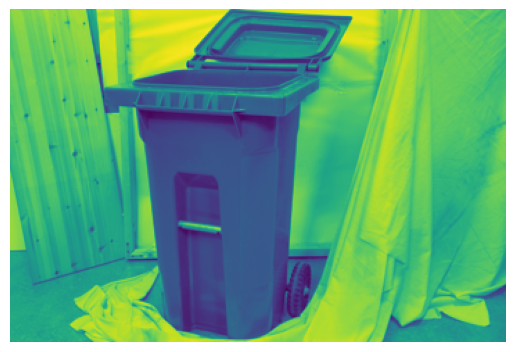

Pre-processing for /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im0.png complete.
Information:
Image size: (358, 240)
Image mode: L


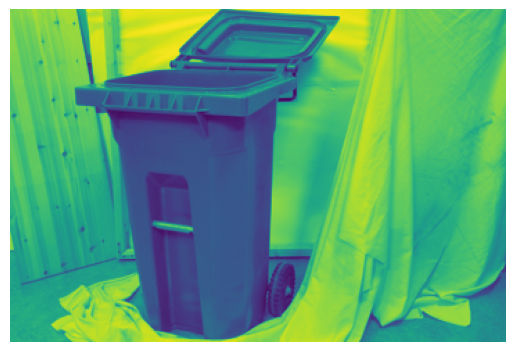

Pre-processing for /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im1.png complete.
Information:
Image size: (358, 240)
Image mode: L


100%|██████████| 232/232 [00:09<00:00, 24.80it/s]


Disparity calculations complete.
Time elapsed during disparity calculations: 9.35959792137146s


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

[[ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 15 15 15]
 [ 0  0  0 ... 14 14 14]
 ...
 [ 0  1  2 ... 15 15 15]
 [ 0  1  2 ... 15 15 15]
 [ 0  1  1 ... 15 15 15]]
27
0
13.178214285714287
Post-processing for disparity matrix of shape (232, 350) complete.


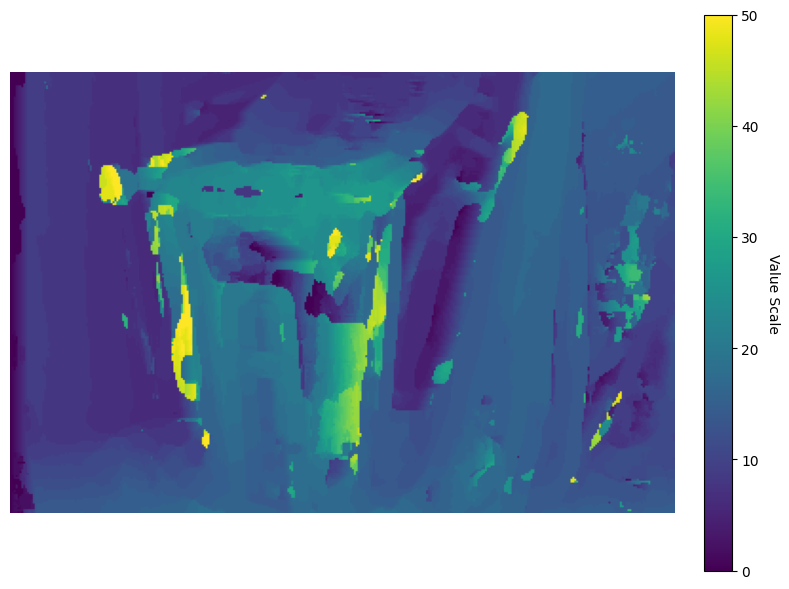

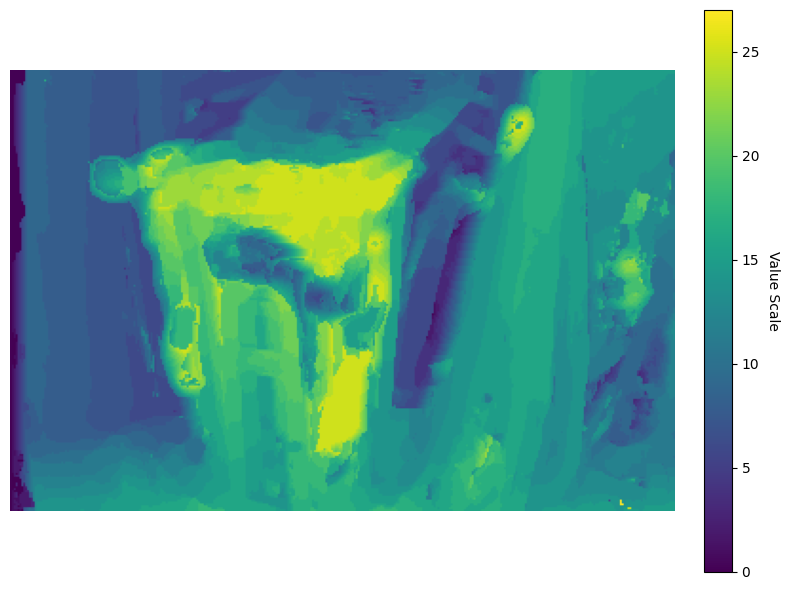

Successfully created file at /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_3d/dustbin_point_cloud_240.txt.
Successfully saved mesh at: /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_3d/dustbin_ply_240.ply


<Figure size 640x480 with 0 Axes>

In [11]:
render_object()